In [213]:
# ============================================================
# 1. IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [214]:
# ============================================================
# 2. Load datasets
# ============================================================

pima  = pd.read_csv("../dataset/diabetes/diabetes.csv")
brfss = pd.read_csv("../dataset/diabetes/diabetes_health.csv")
hosp  = pd.read_csv("../dataset/diabetes/diabetic_data.csv")


In [215]:
# 3. PIMA PROCESSING (TRUE GLUCOSE)
# ============================================================
zero_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in zero_cols:
    pima[c] = pima[c].replace(0, pima[c].median())

pima["HighBP"] = (pima["BloodPressure"] >= 80).astype(int)
pima["HighChol"] = (pima["BMI"] >= 30).astype(int)
pima["GlucoseProxy"] = pima["Glucose"]

pima_final = pima[["Age","BMI","HighBP","HighChol","GlucoseProxy","Outcome"]].copy()

pima_final["RiskScore"] = (
    0.3*pima_final["BMI"] +
    0.3*pima_final["GlucoseProxy"] +
    5*pima_final["HighBP"] +
    4*pima_final["HighChol"] +
    0.1*pima_final["Age"]
)

In [216]:
# 4. BRFSS PROCESSING (RISK + GLUCOSE PROXY)
# ============================================================
brfss = brfss[brfss["Diabetes_012"] != 2].copy()
brfss["Outcome"] = brfss["Diabetes_012"]

brfss["GlucoseProxy"] = (
    brfss["BMI"] * 0.3 +
    brfss["HighBP"] * 10 +
    brfss["HighChol"] * 8 +
    brfss["GenHlth"] * 2
)

brfss_final = brfss[["Age","BMI","HighBP","HighChol","GlucoseProxy","Outcome"]].copy()

brfss_final["RiskScore"] = (
    0.3*brfss_final["BMI"] +
    0.3*brfss_final["GlucoseProxy"] +
    5*brfss_final["HighBP"] +
    4*brfss_final["HighChol"] +
    0.1*brfss_final["Age"]
)


In [217]:
# 5. HOSPITAL PROCESSING
# ============================================================
hosp = hosp.replace("?", np.nan).dropna()

hosp["Outcome"] = hosp["readmitted"].apply(lambda x: 1 if x in ["<30", ">30"] else 0)
hosp["Age"] = hosp["age"].str.extract(r"(\d+)").astype(float)

glu_map = {"None":0, "Norm":100, ">200":220, ">300":320}
hosp["GlucoseProxy"] = hosp["max_glu_serum"].map(glu_map).fillna(0).astype(float)

hosp["BMI"] = (
    hosp["num_medications"].astype(float)*0.6 +
    hosp["num_lab_procedures"].astype(float)*0.2 +
    hosp["time_in_hospital"].astype(float)*2
)

hosp["HighBP"] = (hosp["time_in_hospital"].astype(float) > 6).astype(int)
hosp["HighChol"] = (hosp["num_medications"].astype(float) > 10).astype(int)

hosp_final = hosp[["Age","BMI","HighBP","HighChol","GlucoseProxy","Outcome"]].copy()

hosp_final["RiskScore"] = (
    0.3*hosp_final["BMI"] +
    0.3*hosp_final["GlucoseProxy"] +
    5*hosp_final["HighBP"] +
    4*hosp_final["HighChol"] +
    0.1*hosp_final["Age"]
)

In [218]:
# 6. COMBINE ALL DATASETS
# ============================================================
combined = pd.concat([pima_final, brfss_final, hosp_final], ignore_index=True)
combined = combined.dropna()

print("Combined:", combined.shape)

Combined: (219102, 7)


/tmp/ipykernel_1089/3488246592.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([pima_final, brfss_final, hosp_final], ignore_index=True)


In [219]:
# 7. DOWNSAMPLE FOR QUICKER TRAINING
combined_small = combined.sample(50000, random_state=42)
print("Downsampled shape:", combined_small.shape)

Downsampled shape: (50000, 7)


In [220]:
major = combined_small[combined_small["Outcome"] == 0]
minor = combined_small[combined_small["Outcome"] == 1]

minor_up = resample(
    minor,
    replace=True,
    n_samples=len(major),
    random_state=42
)

balanced = pd.concat([major, minor_up]).sample(frac=1, random_state=42)

print("Balanced distribution:")
print(balanced["Outcome"].value_counts())

Balanced distribution:
Outcome
1.0    48875
0.0    48875
Name: count, dtype: int64


In [221]:
# 8. EXTRA FEATURES: SeverityScore, SeverityScore2
# ============================================================
balanced["SeverityScore"] = (
    0.4*balanced["RiskScore"] +
    0.2*balanced["BMI"] +
    0.2*balanced["GlucoseProxy"] +
    0.2*balanced["HighBP"]
)

balanced["SeverityScore2"] = (
    0.5*balanced["GlucoseProxy"] +
    0.3*balanced["RiskScore"] +
    0.1*balanced["BMI"] +
    0.1*balanced["HighBP"]
)

In [222]:
# 9. TRAIN-TEST SPLIT + SCALING
# ============================================================
features = [
    "Age","BMI","HighBP","HighChol",
    "GlucoseProxy","RiskScore","SeverityScore","SeverityScore2"
]

X = balanced[features]
y = balanced["Outcome"]

In [223]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

cv_accuracy = cross_val_score(cv_pipeline, X, y, cv=skf, scoring='accuracy')
cv_auc = cross_val_score(cv_pipeline, X, y, cv=skf, scoring='roc_auc')
cv_f1 = cross_val_score(cv_pipeline, X, y, cv=skf, scoring='f1')

print("CV Accuracy:", cv_accuracy.mean())
print("CV ROC-AUC:", cv_auc.mean())
print("CV F1:", cv_f1.mean())


CV Accuracy: 0.6831202046035806
CV ROC-AUC: 0.7521539749216712
CV F1: 0.6841731266512215


In [224]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [225]:
# 10. BASE MODELS: XGBoost + RandomForest
# ============================================================
neg = sum(y_train == 0)
pos = sum(y_train == 1)

xgb = XGBClassifier(
    n_estimators=450,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    eval_metric="logloss",
    tree_method="hist",
)

rf = RandomForestClassifier(
    n_estimators=250,
    n_jobs=-1,
    random_state=42
)

In [226]:
# 11. STACKING MODEL (RF + XGB -> Logistic Regression)
# ============================================================
stack = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    n_jobs=-1
)

In [227]:
stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)

print("\n=== STACKING MODEL RESULTS (Balanced 1:1) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


=== STACKING MODEL RESULTS (Balanced 1:1) ===
Accuracy: 0.8739130434782608

Confusion matrix:
 [[8010 1765]
 [ 700 9075]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      9775
         1.0       0.84      0.93      0.88      9775

    accuracy                           0.87     19550
   macro avg       0.88      0.87      0.87     19550
weighted avg       0.88      0.87      0.87     19550



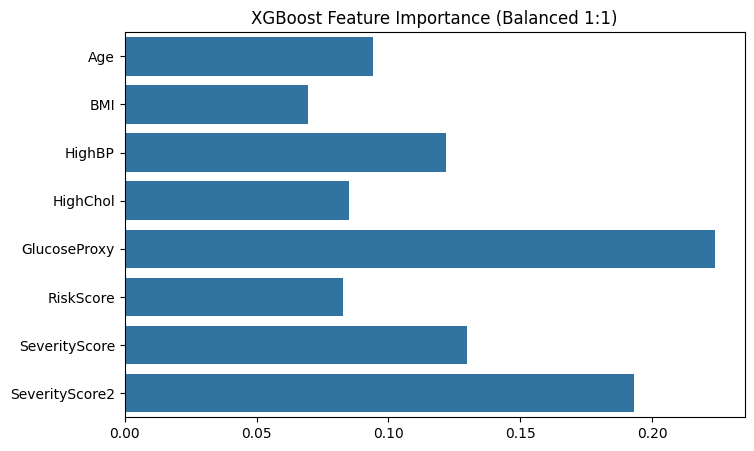

In [228]:
# 12. FEATURE IMPORTANCE (FROM XGBOOST)
# ============================================================
xgb.fit(X_train_scaled, y_train)
imp = xgb.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=imp, y=features)
plt.title("XGBoost Feature Importance (Balanced 1:1)")
plt.show()

In [ ]:
#13. SAVE THE MODEL ARTIFACTS
import joblib
import os

# make sure folder exists (from inside "disease models" notebook)
os.makedirs("../saved_models", exist_ok=True)

artifacts = {
    "model": stack,          # your final stacking model
    "scaler": scaler,        # StandardScaler you fitted
    "features": features     # list of feature column names
}

joblib.dump(artifacts, "../saved_mdl/diabetes_model.pkl")


Model saved to ../saved_models/diabetes_model.pkl


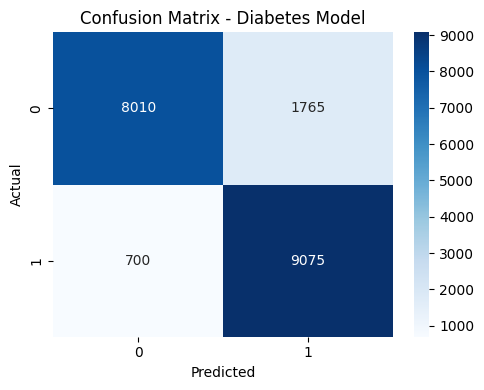

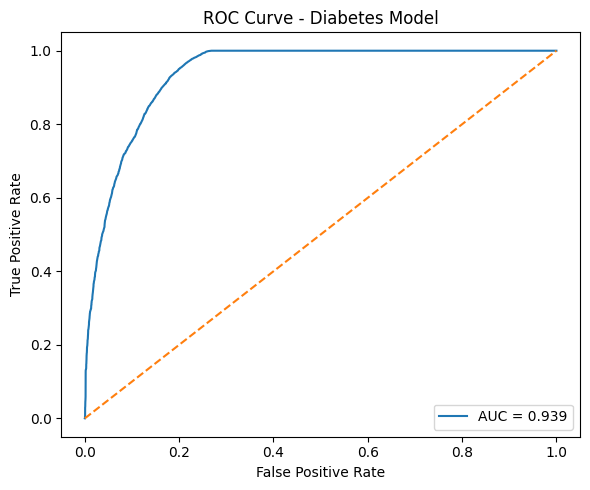

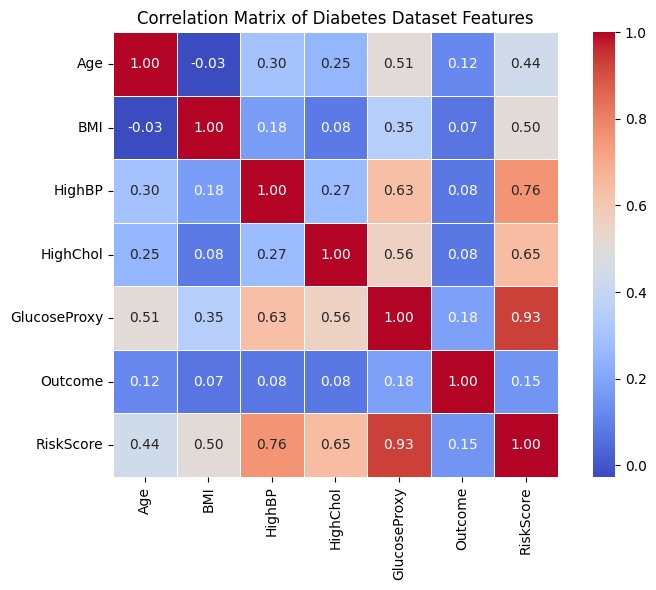

In [230]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Predictions (CORRECT VARIABLES)
# ===============================
y_pred = stack.predict(X_test_scaled)
y_prob = stack.predict_proba(X_test_scaled)[:, 1]


# ===============================
# CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Diabetes Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ===============================
# ROC CURVE
# ===============================
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Diabetes Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

corr_matrix = combined_small.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

plt.title("Correlation Matrix of Diabetes Dataset Features")
plt.tight_layout()
plt.show()